In [72]:
from pygraph.classes.graph import graph
from pygraph.readwrite import dot
from pygraph.algorithms.minmax import shortest_path
from pygraph.algorithms.accessibility import connected_components

In [145]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

In [161]:
import itertools
import random
import statistics

In [43]:
from IPython.core.display import Image, display

In [103]:
def construct_graph_filtered(old_graph, node_predicate, egde_predicate):
    new_graph = graph()
    for node in old_graph.nodes():
        if node_predicate(node):
            new_graph.add_node(node)
    for edge in old_graph.edges():
        if not new_graph.has_edge(edge):
            if node_predicate(edge[0]) and node_predicate(edge[1]) and egde_predicate(edge):
                new_graph.add_edge(edge)
    return new_graph

In [82]:
class CoathorNetwork:
    def __init__(self):
        self.articles = []
        self.author_to_article = {}
        self.gr = graph()
        
    def add_article(self, atricle):
        idx = len(self.articles)
        self.articles.append(atricle)
        # Lookup table for each author
        for author in atricle.authors:
            author = author.strip()
            articles_of_author = self.author_to_article.get(author, [])
            articles_of_author.append(idx)
            self.author_to_article[author] = articles_of_author
            # Add author to graph if not exists
            if not self.gr.has_node(author):
                self.gr.add_node(author)
        # Add authors to graph
        for pair in itertools.combinations(atricle.authors, 2):
            if not self.gr.has_edge(pair):
                self.gr.add_edge(pair);
    
    def write_dot(filename):
        f = open(filename, 'w')
        f.write(dot.write(self.gr))
        f.close()

In [7]:
class Article:
    def __init__(self, title, authors, year, journal, abstract, cite):
        self.title = title
        self.authors = authors
        self.cite = cite
        self.year = int(year)
        self.journal = journal               
    

In [36]:
def load_authors_dataset(filename):
    f = open(filename, 'r')
    for line in f:
        [journal, title, authors, year, abstract] = line.split("\t")
        yield Article(title, authors.split(",") if authors != "" else [], year, journal, abstract, [])    

In [84]:
def analyse(file):
    coauthorNetwork = CoathorNetwork()
    for article in load_authors_dataset(file):
        coauthorNetwork.add_article(article)

    print("Uniq authors:", len([x for x in coauthorNetwork.author_to_article.keys()]))
    return coauthorNetwork
    
file = "./data/authors/Medical Informatics.txt"
coauthorNetwork = analyse(file)
components = connected_components(coauthorNetwork.gr)


#!dot 'graph.dot' -Tpng -o "graph.png"
#display(Image('graph.png' ))

Uniq authors: 7343


In [143]:
# calculate distance distribution for 
# detect small world phenomenon
def get_distance_stat(graph, n):
    stat = {}
    summ = len(graph.nodes()) * n
    for i in range(n):
        random_author = random.choice(graph.nodes())
        distances = shortest_path(graph, random_author)[1]
        for x in distances.values():
            stat[x] = stat.get(x, 0) + 1;
    return dict( (key, value / summ) for key, value in stat.items() )
        

2351
mean 6.615142492556358


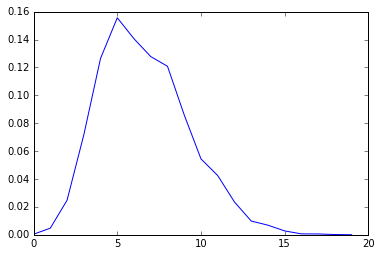

192
mean 6.141927083333333


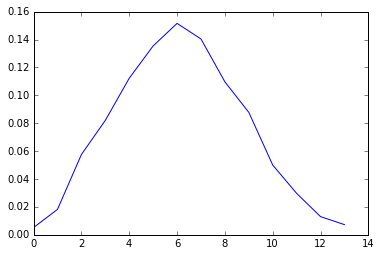

In [171]:
def analize_components(coauthorNetwork, components, component_num):
    PRECISION = 20 # number of authors to calc avg distance
    component_count = max(components.values())

    component_sizes = {}

    for author, component in components.items():
        component_sizes[component] = component_sizes.get(component, 0) + 1

    top10_components = sorted(component_sizes.items(), key = lambda pair: -pair[1])[0:10]

    top1_component = top10_components[component_num][0]

    top1_subgraph = construct_graph_filtered(coauthorNetwork.gr,
                                             lambda node: components[node] == top1_component,
                                             lambda egde: True)
    
    print(len(top1_subgraph.nodes()))
    stat = get_distance_stat(top1_subgraph, PRECISION)
    #print(stat)
    print("mean", sum([value * key for key, value in stat.items()]))
    plt.plot([x for x in stat.keys()], [x for x in stat.values()])
    plt.show()

analize_components(coauthorNetwork, components, 0)
analize_components(coauthorNetwork, components, 1)


In [55]:
for key, value in coauthorNetwork.author_to_article.items():
    if len(value) > 1:
        pass
        #print(key)

In [120]:
dict( (key, value / 2) for key, value in {1:2}.items() )

{1: 1.0}

In [142]:
3/2

1.5